*本程式使用Google* Colab運行

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns
import tensorflow as tf
import keras
from tqdm import tqdm
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.metrics import confusion_matrix , accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import glob
import pandas as pan
import matplotlib.pyplot as plotter
import warnings
warnings.filterwarnings('ignore')

介接Google雲端

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


從資料夾取得資料並Shuffle

In [ ]:

image_data= 'drive/MyDrive/garbage_classification'
files = [i for i in glob.glob(image_data + "//*//*")]
np.random.shuffle(files)
labels = [os.path.dirname(i).split("/")[-1] for i in files]
data = zip(files, labels)

In [ ]:
train_data_dir =image_data
batch_size = 128                           # de 32 para 128
target_size = (224,224)
validation_split = 0.2

處理訓練與驗證資料

In [ ]:
train= tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="training",
    seed=50,                                                         # de 100 para 50
    image_size=target_size,
    batch_size=batch_size,
)
validation= tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="validation",
    seed=100,                                                         # de 200 para 100
    image_size=target_size,
    batch_size=batch_size,
)
class_names = train.class_names
class_names

Found 3031 files belonging to 6 classes.
Using 2425 files for training.
Found 3031 files belonging to 6 classes.
Using 606 files for validation.


['cardboard', 'metal', 'paper', 'plastic', 'trash', 'white-glass']

模型設計

In [ ]:
def create_model():
  model = keras.Sequential([
      keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
      keras.layers.MaxPooling2D((2, 2)),
      keras.layers.Conv2D(32, (3, 3), activation='relu',),
      keras.layers.MaxPooling2D((2, 2)),
      keras.layers.Dense(512, activation='relu'),
      keras.layers.Dropout(0.2),
      keras.layers.Flatten(),
      keras.layers.Dense(256, activation='relu'),
      keras.layers.Dense(64, activation='relu'),
      keras.layers.Dense(6)
  ])

  model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
  return model




訓練Model

In [ ]:
model=create_model()
#model.load_weights('drive/MyDrive/model_h5/my_keras_model_1_4.h5')
checkpoint =ModelCheckpoint("drive/MyDrive/model_h5/my_keras_model_1_6.h5", save_best_only=True)
early_stopping =EarlyStopping(patience=10, restore_best_weights=True)
# Compile the model
hist=model.fit_generator(train,epochs=10,validation_data=validation,callbacks=[checkpoint,early_stopping])

圖像化訓練過程

5/5 [==============================] - 3s 115ms/step - loss: 2.8441 - accuracy: 0.8168


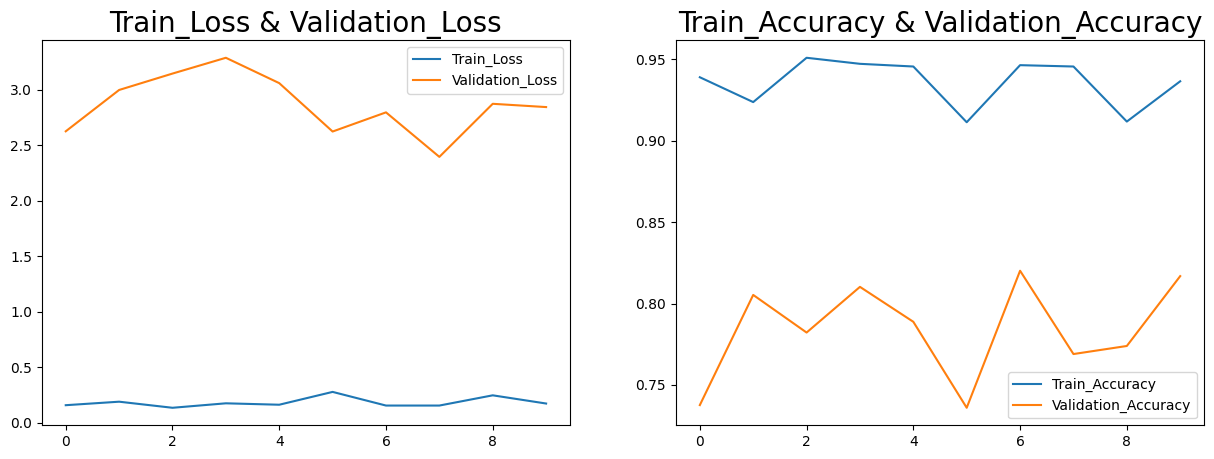

In [ ]:
score, acc = model.evaluate(validation)
hist_=pd.DataFrame(hist.history)
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()

使用測試資料預測

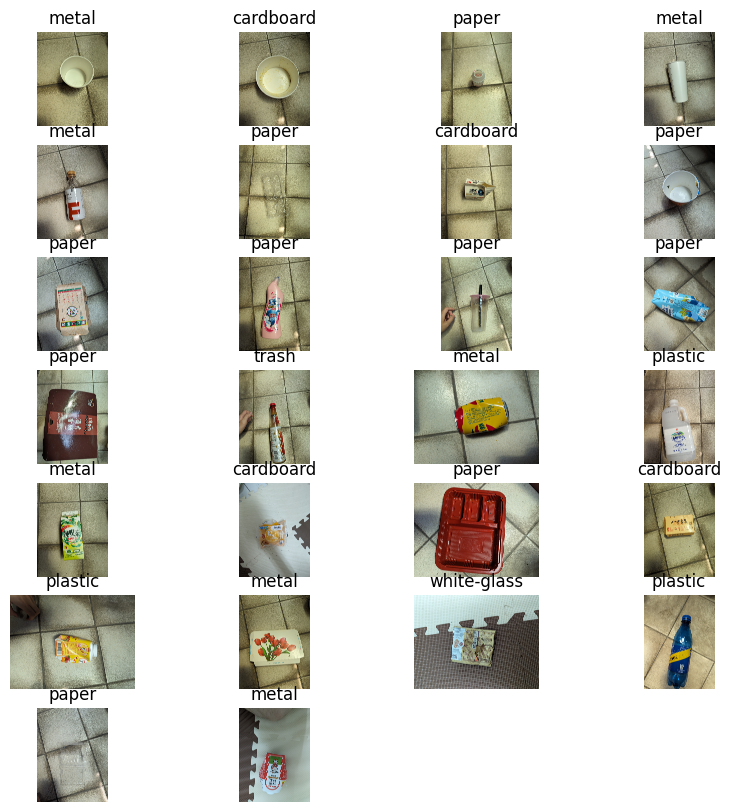

In [ ]:
test_data= 'drive/MyDrive/garbage_test'
test_files = [i for i in glob.glob(test_data + "//*")]
i=0
plt.figure(figsize=(10,10))
for path in test_files:
  image=keras.utils.load_img(
      path,
      color_mode="rgb",
      target_size=(224,224),
      interpolation="nearest",
      keep_aspect_ratio=False,
  )
  input_arr = keras.utils.img_to_array(image)
  input_arr = np.array([input_arr])  # Convert single image to a batch.
  predictions = np.argmax(model.predict(input_arr,verbose=0),axis=1)
  image = img.imread(path)
  ax = plt.subplot(7, 4, i + 1)
  plt.imshow(image)
  plt.title(class_names[predictions[0]])
  plt.axis("off")
  i+=1